In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import cmcrameri.cm as ccm
import cmocean.cm as cmo

# Visualizing drought risk and catchment properties relevant to NBS

In [4]:
ddir = "../Data/"
de = pd.read_csv(ddir + "drought_events.csv", delimiter=";", decimal=',')
de = de.rename({"station": "gauge_id"}, axis='columns')
dt30 = pd.read_csv(ddir + "DT30.csv", delimiter=";", decimal=',')
dt30 = dt30.rename({"station": "gauge_id"}, axis='columns')
dt30c = pd.read_csv(ddir + "DT30_change.csv", delimiter=";", decimal=',')
dt30c = dt30c.rename({"station": "gauge_id"}, axis='columns')
dt30u = pd.read_csv(ddir + "DT30_change_uncertainty.csv", delimiter=";", decimal=',')
dt30u = dt30u.rename({"station": "gauge_id"}, axis='columns')

## Loading data and joining geometries:

In [209]:
# load camels topographic info
clim_cgb = pd.read_csv(ddir + "camels-gb/data/CAMELS_GB_climatic_attributes.csv")
# clim_cgb = clim_cgb.rename({"ID": "station_ID"}, axis='columns')
hi_cgb = pd.read_csv(ddir + "camels-gb/data/CAMELS_GB_humaninfluence_attributes.csv")
# hi_cgb = hi_cgb.rename({"ID": "station_ID"}, axis='columns')
hg_cgb = pd.read_csv(ddir + "camels-gb/data/CAMELS_GB_hydrogeology_attributes.csv")
# hg_cgb = hg_cgb.rename({"ID": "station_ID"}, axis='columns')
hyd_cgb = pd.read_csv(ddir + "camels-gb/data/CAMELS_GB_hydrologic_attributes.csv")
# hyd_cgb = hyd_cgb.rename({"ID": "station_ID"}, axis='columns')
hm_cgb = pd.read_csv(ddir + "camels-gb/data/CAMELS_GB_hydrometry_attributes.csv")
# hm_cgb = hm_cgb.rename({"ID": "station_ID"}, axis='columns')
lc_cgb = pd.read_csv(ddir + "camels-gb/data/CAMELS_GB_landcover_attributes.csv")
# lc_cgb = lc_cgb.rename({"ID": "station_ID"}, axis='columns')
soil_cgb = pd.read_csv(ddir + "camels-gb/data/CAMELS_GB_soil_attributes.csv")
# soil_cgb = soil_cgb.rename({"ID": "station_ID"}, axis='columns')
topo_cgb = pd.read_csv(ddir + "camels-gb/data/CAMELS_GB_topographic_attributes.csv")
# topo_cgb = topo_cgb.rename({"ID": "station_ID"}, axis='columns')
# other
abstr_scot = pd.read_csv(ddir + "scot_agri_abstr_gordon.csv")  # well that's not very useful


In [6]:
# load camels catchment boundaries
poly_cgb = gpd.read_file(ddir + "camels-gb/data/CAMELS_GB_catchment_boundaries/CAMELS_GB_catchment_boundaries.shp")
poly_cgb = poly_cgb.rename({"ID": "gauge_id"}, axis='columns')

In [7]:
# join data to the shapefiles
# Camels-GB
geo_clim_cgb = poly_cgb.merge(clim_cgb, on="gauge_id")
geo_clim_cgb = geo_clim_cgb.set_index('gauge_id')
geo_hi_cgb = poly_cgb.merge(hi_cgb, on="gauge_id")
geo_hi_cgb = geo_hi_cgb.set_index('gauge_id')
geo_hg_cgb = poly_cgb.merge(hg_cgb, on="gauge_id")
geo_hg_cgb = geo_hg_cgb.set_index('gauge_id')
geo_hyd_cgb = poly_cgb.merge(hyd_cgb, on="gauge_id")
geo_hyd_cgb = geo_hyd_cgb.set_index('gauge_id')
geo_hm_cgb = poly_cgb.merge(hm_cgb, on="gauge_id")
geo_hm_cgb = geo_hm_cgb.set_index('gauge_id')
geo_lc_cgb = poly_cgb.merge(lc_cgb, on="gauge_id")
geo_lc_cgb = geo_lc_cgb.set_index('gauge_id')
geo_soil_cgb = poly_cgb.merge(soil_cgb, on="gauge_id")
geo_soil_cgb = geo_soil_cgb.set_index('gauge_id')
geo_topo_cgb = poly_cgb.merge(topo_cgb, on="gauge_id")
geo_topo_cgb = geo_topo_cgb.set_index('gauge_id')
# EDGE
geo_de = poly_cgb.merge(de, on="gauge_id")
geo_de = geo_de.set_index('gauge_id')
geo_dt30 = poly_cgb.merge(dt30, on="gauge_id")
geo_dt30 = geo_dt30.set_index('gauge_id')
geo_dt30c = poly_cgb.merge(dt30c, on="gauge_id")
geo_dt30c = geo_dt30c.set_index('gauge_id')
geo_dt30u = poly_cgb.merge(dt30u, on="gauge_id")
geo_dt30u = geo_dt30u.set_index('gauge_id')


In [9]:
# identify gauges that are in CGB and dt30:
stations_analyzed = set(de['gauge_id'].unique())
stations_cgb = set(poly_cgb['gauge_id'].unique())
stations_common = stations_cgb.intersection(stations_analyzed)
len(stations_analyzed)  # 248
len(stations_common)   # 193

193

## mild preprocessing of catchment attrs

In [190]:
geo_lc_cgb['wood_perc'] = geo_lc_cgb['dwood_perc']+geo_lc_cgb['ewood_perc']
geo_hi_cgb['total_abs'] = geo_hi_cgb['surfacewater_abs'] + geo_hi_cgb['groundwater_abs']
geo_hi_cgb['abs_agriculture_mm-d'] = geo_hi_cgb['total_abs'] * geo_hi_cgb['abs_agriculture_perc'] / 100
geo_hi_cgb['abs_environmental_mm-d'] = geo_hi_cgb['total_abs'] * geo_hi_cgb['abs_environmental_perc'] / 100

0      325.721875
1      532.286875
2      158.183125
3       30.611563
4       24.310625
          ...    
666    138.460625
667    193.726562
668    474.017812
669    105.349375
670    414.477188
Length: 671, dtype: float64

## plot catchment attrs

In [ ]:
# plot
ncol=3
nrow=2
fig,axes = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*5))
axes=axes.ravel()
geo_lc_cgb.loc[stations_common,:].plot(column="crop_perc", legend=True,
                                       cmap="magma", ax=axes[0])
axes[0].set_title("Crop (%)")
geo_lc_cgb.loc[stations_common,:].plot(column="grass_perc", legend=True,
                                       cmap="magma", ax=axes[1])
axes[1].set_title("Grass (%)")
geo_lc_cgb.loc[stations_common,:].plot(column="wood_perc", legend=True,
                                       cmap="magma", ax=axes[2])
axes[2].set_title("Evergreen + Decidious wood (%)")
geo_lc_cgb.loc[stations_common,:].plot(column="bares_perc", legend=True,
                                       cmap="magma", ax=axes[3])
axes[3].set_title("Bare soil and rock (%)")
geo_lc_cgb.loc[stations_common,:].plot(column="shrub_perc", legend=True,
                                       cmap="magma", ax=axes[4])
axes[4].set_title("Shrub (%)")
geo_lc_cgb.loc[stations_common,:].plot(column="urban_perc", legend=True,
                                       cmap="magma", ax=axes[5])
axes[5].set_title("Urban (%)")
plt.savefig("../figures/land-cover_camelsgb_analyzedcatchments.png")

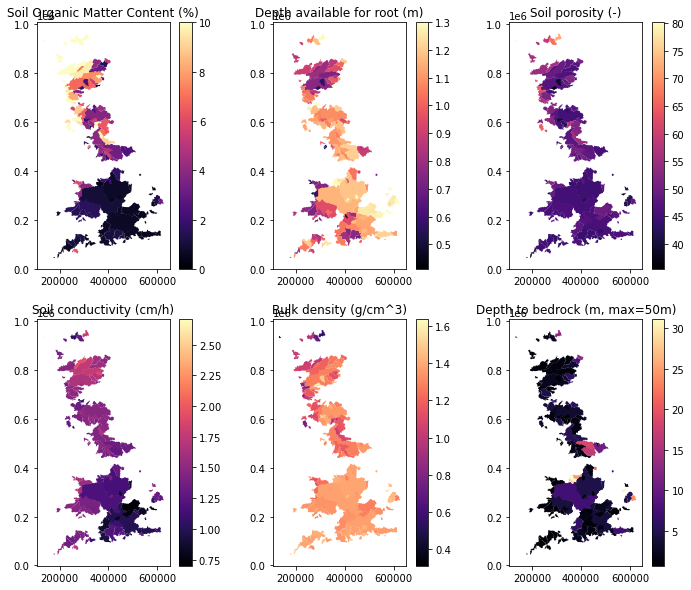

In [62]:
ncol=3
nrow=2
fig,axes = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*5))
axes=axes.ravel()
geo_soil_cgb.loc[stations_common,:].plot(column="organic_perc", legend=True,
                                         cmap="magma", ax=axes[0], vmin=0, vmax=10)
axes[0].set_title("Soil Organic Matter Content (%)")
geo_soil_cgb.loc[stations_common, :].plot(column='root_depth', legend=True,
                                          cmap="magma", ax=axes[1])
axes[1].set_title("Depth available for root (m)")
geo_soil_cgb.loc[stations_common, :].plot(column='porosity_hypres', legend=True,
                                          cmap="magma", ax=axes[2])
axes[2].set_title("Soil porosity (-)")
geo_soil_cgb.loc[stations_common, :].plot(column='conductivity_hypres', legend=True,
                                          cmap="magma", ax=axes[3])
axes[3].set_title("Soil conductivity (cm/h)")
geo_soil_cgb.loc[stations_common, :].plot(column='bulkdens', legend=True,
                                          cmap="magma", ax=axes[4])
axes[4].set_title("Bulk density (g/cm^3)")
geo_soil_cgb.loc[stations_common, :].plot(column='soil_depth_pelletier', legend=True,
                                          cmap="magma", ax=axes[5])
axes[5].set_title("Depth to bedrock (m, max=50m)")
plt.savefig("../figures/soil_properties_for_NBS_improvement.png")

KeyboardInterrupt: 

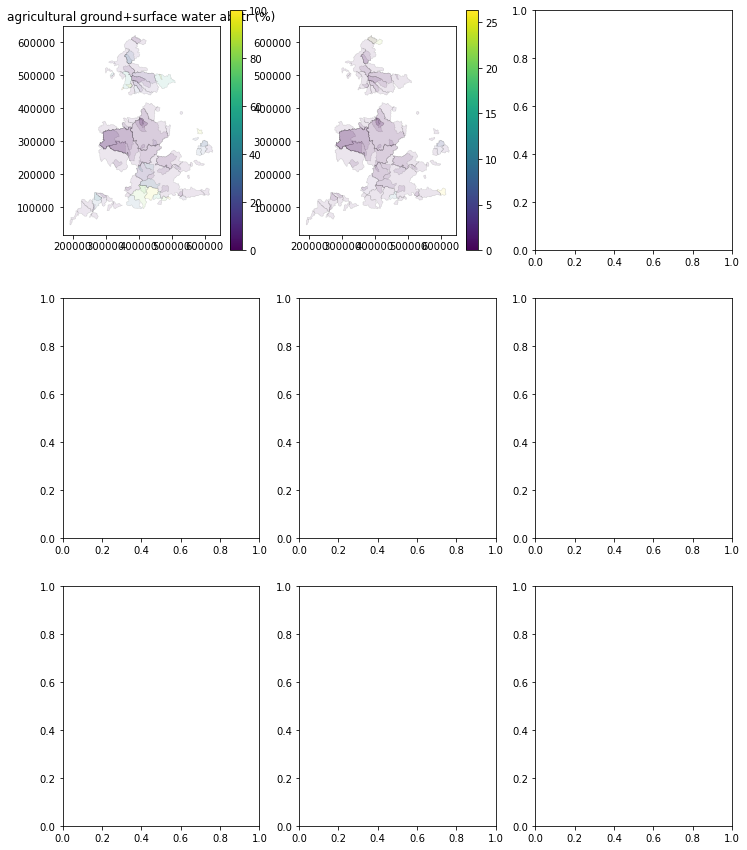

In [63]:
ncol=3
nrow=3
colmap = 'viridis'
alpha=0.1
fig,axes = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*5))
axes=axes.ravel()
geo_hi_cgb.loc[stations_common, :].plot(column='abs_agriculture_perc', legend=True,
                                          cmap=colmap, ax=axes[0], edgecolor='k', linewidth=0.5, alpha=alpha)
axes[0].set_title("agricultural ground+surface water abstr (%)")
geo_hi_cgb.loc[stations_common, :].plot(column='abs_environmental_perc', legend=True,
                                          cmap=colmap, ax=axes[1], edgecolor='k', linewidth=0.5, alpha=alpha)
axes[1].set_title("environmental ground+surface water abstr (%)")
geo_hi_cgb.loc[stations_common, :].plot(column='surfacewater_abs', legend=True,
                                          cmap=colmap, ax=axes[2], edgecolor='k', linewidth=0.5, alpha=alpha)
axes[2].set_title("mean surface water abstr (mm/d)")
geo_hi_cgb.loc[stations_common, :].plot(column='groundwater_abs', legend=True,
                                          cmap=colmap, ax=axes[3], edgecolor='k', linewidth=0.5, alpha=alpha)
axes[3].set_title("mean groundwater abstraction (mm/d)")
geo_hi_cgb.loc[stations_common, :].plot(column='total_abs', legend=True,
                                          cmap=colmap, ax=axes[4], edgecolor='k', linewidth=0.5, alpha=alpha)
axes[4].set_title("mean combined abstraction (mm/d)")
geo_hi_cgb.loc[stations_common, :].plot(column='abs_agriculture_mm-d', legend=True,
                                          cmap=colmap, ax=axes[5], edgecolor='k', linewidth=0.5, alpha=alpha)
axes[5].set_title("agricultural ground+surface water abstr (mm/d)")
geo_hi_cgb.loc[stations_common, :].plot(column='abs_environmental_mm-d', legend=True,
                                          cmap=colmap, ax=axes[6], edgecolor='k', linewidth=0.5, alpha=alpha)
axes[6].set_title("environmental ground+surface water abstr (mm/d)")
plt.savefig("../figures/abstraction_data.png")

In [ ]:
geo_clim_cgb.columns

In [ ]:
geo_hg_cgb.columns

In [ ]:
geo_hi_cgb.columns

In [ ]:
geo_soil_cgb.columns

In [ ]:
geo_hm_cgb.columns

In [ ]:
geo_hyd_cgb.columns

In [ ]:
geo_hm_cgb.columns

In [ ]:
geo_topo_cgb.columns

In [ ]:
geo_lc_cgb.columns

## Catchment attributes

In [264]:
IDs_interest = [50001, 12008]  # glen, nw

IDs_interest = [15006, 6007, 28022, 28009, 8006, 54057, 54032, 55023,67015,
                54005, 21009, 54001]#, 55002, 94001, 39001, 12002]

# selecting attributes for catchments
poly_cgb = poly_cgb.set_index("gauge_id")
crop_selected = geo_lc_cgb.loc[IDs_interest]["crop_perc"]
grass_selected = geo_lc_cgb.loc[IDs_interest]["grass_perc"]
soc_selected = geo_soil_cgb.loc[IDs_interest]["organic_perc"]
tawc_selected = geo_soil_cgb.loc[IDs_interest]["tawc"]
area_selected = poly_cgb.loc[IDs_interest]['geometry'].area / 1000000  # square kilometers
agrabs_selected = geo_hi_cgb.loc[IDs_interest]["abs_agriculture_perc"]
# concat these for boxplotting
dfs = [crop_selected, grass_selected, soc_selected, tawc_selected]
relevant_attrs = pd.concat(dfs, axis=1)
relevant_attrs = relevant_attrs.rename({"crop_perc": "% Crop", "grass_perc": "% Grass",
                                        "organic_perc": "% Soil Organic Carbon",
                                        "tawc": "TAWC (mm)",
                                        "abs_agriculture_perc": "% Agricultural abstr."}, axis=1)
poly_cgb=poly_cgb.reset_index()

total_selected_crop = ((crop_selected/100) * area_selected).sum()
total_selected_grass = ((grass_selected/100) * area_selected).sum()

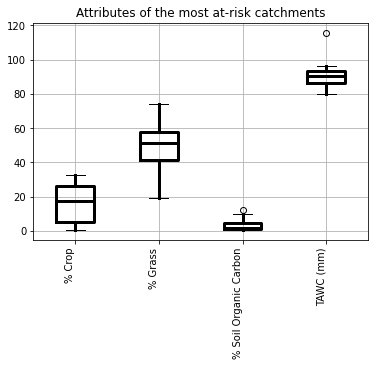

In [265]:
ax = relevant_attrs.boxplot(color = {'whiskers' : 'black',
                                     'caps' : 'black',
                                     'medians' : 'black',
                                     'boxes' : 'black'},
                            whiskerprops = {'linewidth' : 3},
                            flierprops = {'linewidth' : 3},
                            medianprops = {'linewidth' : 3},
                            boxprops = {'linewidth' : 3})

for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(90)
ax.set_title("Attributes of the most at-risk catchments")
plt.savefig("../figures/problem_catchment_properties.pdf")

## scratchpad/debugging stuff??

In [ ]:
geo_soil_cgb.loc[stations_common,:][geo_soil_cgb["organic_perc_missing"] < 0.5].plot("organic_perc", linewidth=0.5,
                                                                                     edgecolor='k', legend=True, alpha=0.1)

## aggregate data and join geometry

In [173]:
# The below line should, for each combination of scenario and gauge_id: compute the sum of the durations and deficits
# for each ensemble member ID, then compute the median across the ensemble.
total_de_by_scen_id_em = de.groupby(["clForce", "gauge_id"]).apply(lambda ds:  ds.groupby("ID").sum().min(axis=0))

# this just merges the above to the shapefiles again
geo_total_de_by_scen_id_em = poly_cgb.merge(total_de_by_scen_id_em[["dur", "deficitSum"]].reset_index(),
                                           on="gauge_id")

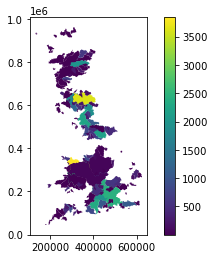

In [174]:
geo_total_de_by_scen_id_em[geo_total_de_by_scen_id_em["clForce"] == "historical"].plot(column="deficitSum",
                                                                                       legend=True,
                                                                                       cmap="viridis")
plt.savefig("../figures/historical_totalofdeficitSum_ensemblemean.png")


# compute and plot change in drought deficit and total time spent in drought during the two periods

In [175]:
# compute absolute change
geo_total_de_by_scen_id_em = geo_total_de_by_scen_id_em.set_index("gauge_id")
total_de_by_scen_id_em_change = (geo_total_de_by_scen_id_em[geo_total_de_by_scen_id_em["clForce"] == "rcp8p5"][["dur", "deficitSum"]] -\
                                 geo_total_de_by_scen_id_em[geo_total_de_by_scen_id_em["clForce"] == "historical"][["dur", "deficitSum"]])/30
geo_total_de_by_scen_id_em = geo_total_de_by_scen_id_em.reset_index()
total_de_by_scen_id_em_change

# join it
geo_total_de_by_scen_id_em_change = poly_cgb.merge(total_de_by_scen_id_em_change, on="gauge_id")

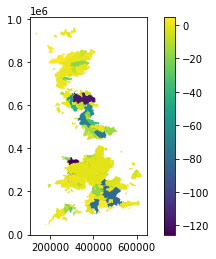

In [176]:
geo_total_de_by_scen_id_em_change.plot(column="deficitSum", cmap="viridis", legend=True)
plt.savefig("../figures/change_totalofdeficitSum_ensemblemean.png")

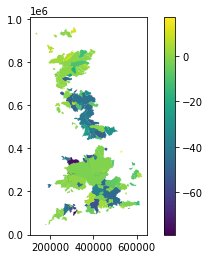

In [177]:
geo_total_de_by_scen_id_em_change.plot(column="dur", cmap="viridis", legend=True)
plt.savefig("../figures/change_totalofdur_ensemblemean.png")

In [178]:
# compute relative change
geo_total_de_by_scen_id_em = geo_total_de_by_scen_id_em.set_index("gauge_id")
total_de_by_scen_id_em_change_relative = (total_de_by_scen_id_em_change / \
                                         geo_total_de_by_scen_id_em[geo_total_de_by_scen_id_em["clForce"] == "historical"][["dur", "deficitSum"]]/30)*100

geo_total_de_by_scen_id_em = geo_total_de_by_scen_id_em.reset_index()

# join it
geo_total_de_by_scen_id_em_change_relative = poly_cgb.merge(total_de_by_scen_id_em_change_relative, on="gauge_id")

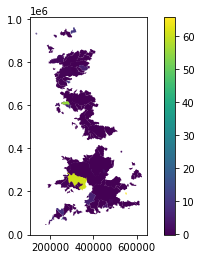

In [179]:
geo_total_de_by_scen_id_em_change_relative.plot(column="deficitSum", cmap="viridis", legend=True)
plt.savefig("../figures/pct-change_totalofdeficitSum_ensemblemean.png")

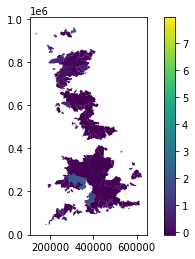

In [180]:
geo_total_de_by_scen_id_em_change_relative.plot(column="dur", cmap="viridis", legend=True)
plt.savefig("../figures/pct-change_totalofdur_ensemblemean.png")